## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Dark](#dark)
* [Flat](#flat)
* [Mask](#mask)
* [Integration](#integration)

TODO
- faire un mask, dark, flat correct. (voir avec SIXS).
- corriger du moniteur. (I0)

In [1]:
%pylab nbagg

import os
import functools

import h5py
import pyFAI

from collections import namedtuple
from itertools import chain
from typing import List, Optional, Tuple

from fabio.edfimage import edfimage
from h5py import File
from pyFAI.detectors import detector_factory
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import ipywidgets as widgets


# local import
from soleil import Angle, Calibrant, CalibrationMarsTxTz, CalibrationFunctions, CalibrationMarsTxTzFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathContainsDefault, DatasetPathWithAttribute, get_dataset,\
    calibration_mars_tx_tz, integrate_mars_tx_tz, save_as_edf_mars_tx_tz

Populating the interactive namespace from numpy and matplotlib


In [2]:
ROOT = "/home/experiences/instrumentation/picca/jupyter/mars/99170118/"
PUBLISHED = os.path.join(ROOT, "published-data")

In [12]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = 0.45
poni1_scale = 0.001
poni1_offset = 0.12
poni1x_scale = 0
poni2_scale = 0.0 # 0.001
poni2_offset = 0.0 # -0.9488181818181818
poni2z_scale = 0
rot1 = 0.0 # 0.00388272369359
rot2 = 0.0 # -0.00942588451226
rot3 = 0.0 # 7.19961198098e-07


functions = (
    CalibrationFunctions("dist",
                         "tz * poni1_scale + poni1_offset + tx * poni1x_scale",
                         "tx * poni2_scale + poni2_offset + tz * poni2z_scale",
                         "rot1",
                         "rot2",
                         "rot3"),    
    [Parameter[Length]("dist", distance, (distance-0.1, distance+0.1)),
     Parameter[float]("poni1_scale", poni1_scale, (poni1_scale, poni1_scale)),
     Parameter[Length]("poni1_offset", poni1_offset, (poni1_offset-1, poni1_offset+1)),
     Parameter[float]("poni1x_scale", poni1x_scale, (poni1x_scale, poni1x_scale)),
     Parameter[float]("poni2_scale", poni2_scale, (poni2_scale, poni2_scale)),
     Parameter[Length]("poni2_offset", poni2_offset, (poni2_offset, poni2_offset)),
     Parameter[float]("poni2z_scale", poni2z_scale, (poni2z_scale, poni2z_scale)),
     Parameter[Angle]("rot1", rot1, (rot1-0.1, rot1+0.1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationMarsTxTzFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

def mkCalibrationMarsTxTz(filename: str, tx: float, tz: float, idxs: List[int]):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd", "calibration"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContainsDefault("scan_data/actuator_1_1", tx),  # tx
                               #tz, # tz
                               DatasetPathContainsDefault("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value", tz),  # tz
                               idxs,
                               to_use,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(1.48840573105e-10),
                               functions,
                               3 ## max_rings
                              ) 
    
params = [mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_71_01.nxs"), 0.0, 0.0, [0])]

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
emacs = my_cmd_button("emacs soleil.py", "Edit the soleil.py file")

In [6]:
for param in params:
    my_cmd_button("silx view --use-opengl-plot " + param.filename,
                  'Silx View ' + os.path.basename(param.filename))

In [13]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

for param in params:
    cmds = save_as_edf_mars_tx_tz(param)
    for cmd, idx in zip(cmds, param.idxs):
        my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(param.filename) + " " + str(idx))

Gtk-Message: Failed to load module "canberra-gtk-module"
  File "/usr/lib/python2.7/dist-packages/silx/gui/plot/PlotActions.py", line 38, in <module>
    since_version='0.6')
LaB6 Calibrant with 1441 reflections 
LaB6 Calibrant with 1441 reflections 
INFO:pyFAI.massif:Image size is (960, 560)
INFO:pyFAI.massif:Binning size is [1, 1]
INFO:pyFAI.massif:Labeling found 7653 massifs.
INFO:pyFAI.massif:Labeling found 7653 massifs.
ERROR:pyFAI.massif:You picked a background point at [449, 294]
INFO:pyFAI.massif:Image size is (960, 560)
INFO:pyFAI.massif:Binning size is [1, 1]
INFO:pyFAI.massif:Labeling found 7653 massifs.
INFO:pyFAI.massif:Labeling found 7653 massifs.
ERROR:pyFAI.massif:You picked a background point at [449, 294]
INFO:pyFAI.massif:Image size is (960, 560)
INFO:pyFAI.massif:Binning size is [1, 1]
INFO:pyFAI.massif:Labeling found 7653 massifs.
INFO:pyFAI.massif:Labeling found 7653 massifs.
ERROR:pyFAI.massif:You picked a background point at [459, 367]
INFO:pyFAI.massif:Image si

In [ ]:
# execute the calibration

calibration_mars_tx_tz(params, json)

area_pixel=2.8040269320227864 area_sum=3.872373118552466, Error= -0.38100425296521295


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


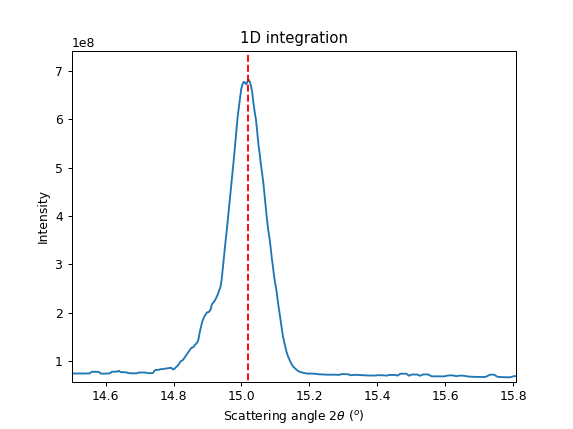

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([       0.        ,  5403927.26027618,  5349190.27035902, ...,
               0.        ,        0.        ,        0.        ]))

In [26]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)

## Mask  <a name="mask"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


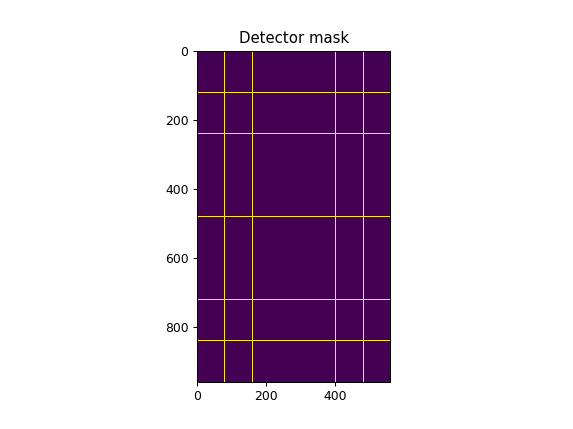

<IPython.core.display.Javascript object>


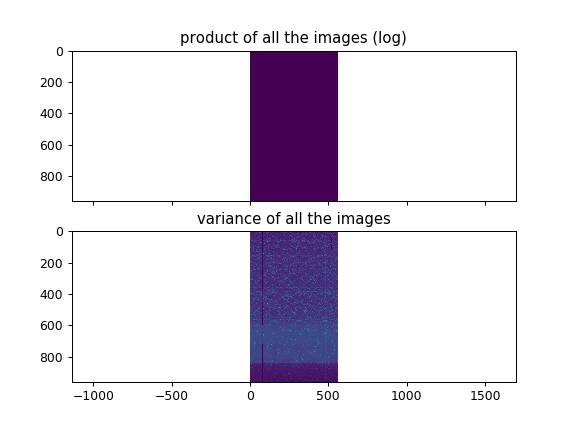

<IPython.core.display.Javascript object>


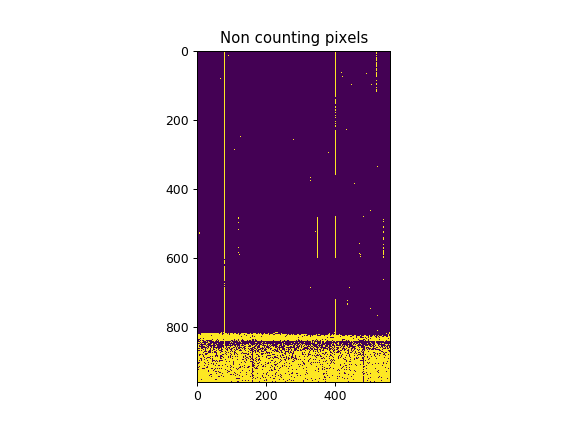

<IPython.core.display.Javascript object>


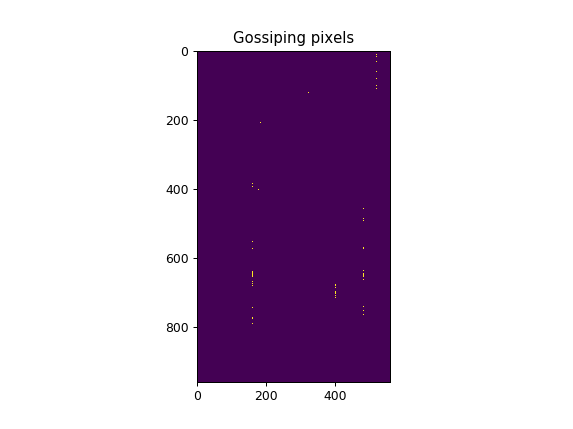

<IPython.core.display.Javascript object>


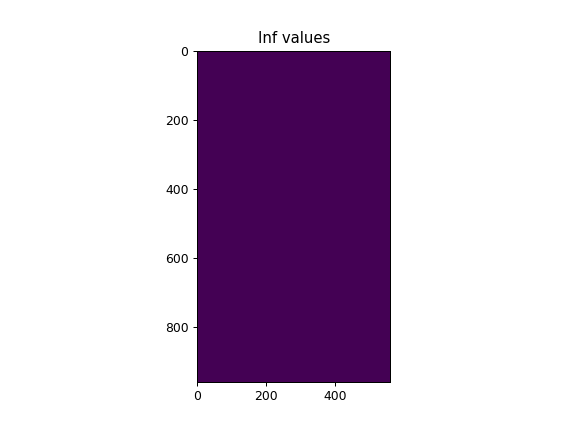

<IPython.core.display.Javascript object>


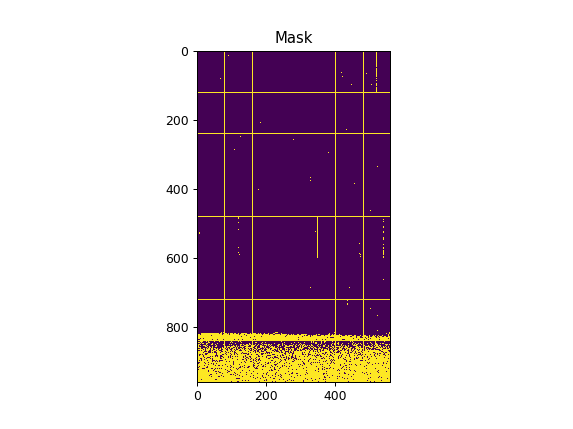

In [27]:
# create a bunch of function used to generate the mask

def mask_from_detector(detector: str) -> numpy.ndarray:
        det = detector_factory(detector)
        mask = det.calc_mask() ## int8
        
        # on a repere des discidents
        #mask[:, 527:529] = 1
        #mask[1, 413] = 1
        #mask[3, 530] = 1
        #mask[186, 333] = 1
        #mask[233, 281] = 1
        
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask)
        ax.set_title("Detector mask")

        return mask
    
def mask_from_data(params: CalibrationMarsTxTz) -> numpy.ndarray:
    prod_threshold = 1
    always_threshold = 660
    prod_gossiping = 1e20
    
    with File(params.filename, mode='r') as h5file:
        images = get_dataset(h5file, params.images_path)[:].astype('double')
        
        # product and variance of all the images
        prod = images.prod(axis=0)
        var = images.var(axis=0)
        fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
        ax0 = ax[0]
        ax0.set_title('product of all the images (log)')
        #ax0.imshow(numpy.log(prod+1.0))
        ax0.imshow(prod)
        ax1 = ax[1]
        ax1.set_title('variance of all the images')
        ax1.imshow(numpy.log(var+1.0))

        # remove the non counting pixels
        mask_non_counting = numpy.where(prod < prod_threshold, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_non_counting)
        ax.set_title("Non counting pixels")
        
        # remove the gossiping pixels
        mask_gossiping = numpy.where(prod > prod_gossiping, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_gossiping)
        ax.set_title("Gossiping pixels")
        
        # remove the inf values
        mask_inf = numpy.isinf(prod).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_inf)
        ax.set_title("Inf values")

        mask = mask_non_counting.copy()
        mask = numpy.logical_or(mask, mask_gossiping)
        mask = numpy.logical_or(mask, mask_inf)
        
        return mask

def mask_from_flat(detector: str,
                   flat: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(flat < 6, 1, 0).astype('int8')
        mask = numpy.logical_or(mask, numpy.where(flat > 20, 1, 0))

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from flat")
        
    return mask

def mask_from_dark(detector: str,
                   dark: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(dark != 0, 1, 0).astype('int8')

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from dark")
        
    return mask

mask = mask_from_detector(params[0].detector)
mask = numpy.logical_or(mask, mask_from_data(params[0]))
#mask = numpy.logical_or(mask, mask_from_flat(params.detector, flat))
#mask = numpy.logical_or(mask, mask_from_dark(params.detector, dark))

fig, ax = pylab.subplots(1, 1, sharex=True, sharey=True)
ax.imshow(mask)
ax.set_title('Mask')

area_pixel=2.8040269320227864 area_sum=3.872373118552466, Error= -0.38100425296521295


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


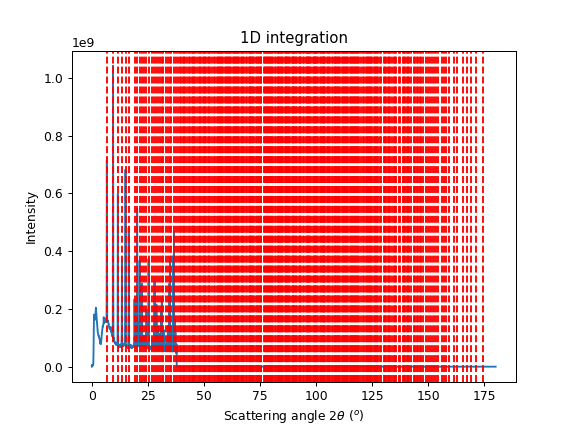

<IPython.core.display.Javascript object>


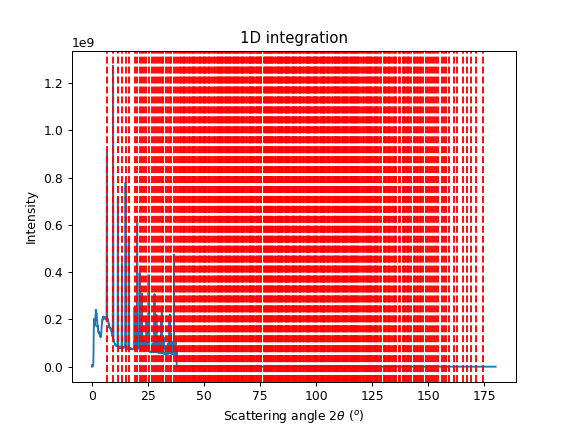

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([       0.        ,  5495590.02198056,  5507701.4390775 , ...,
               0.        ,        0.        ,        0.        ]))

In [28]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)
integrate_mars_tx_tz(json, params, f, lst_mask=mask, plot_calibrant=True, n=50000)

In [ ]:
# il faudrait faire une calibration avec l'ensemble des fichiers des scan3 et 4.
# scan3 10 images tx variant et tz=0.
# scan4 10 imagfes tx variant et tz = -1.

# TODO add the second scan for the calibration.
# TODO mask

## Integration <a name="integration"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


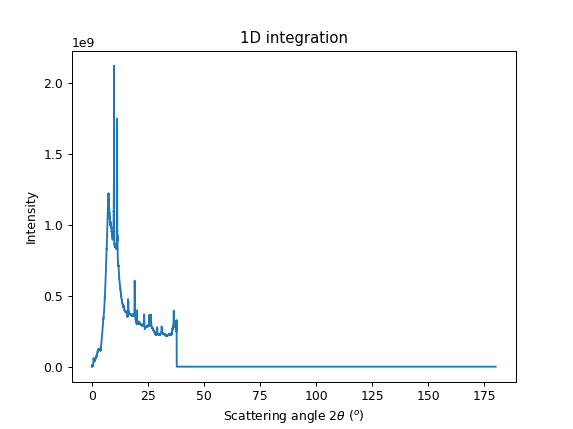

<IPython.core.display.Javascript object>


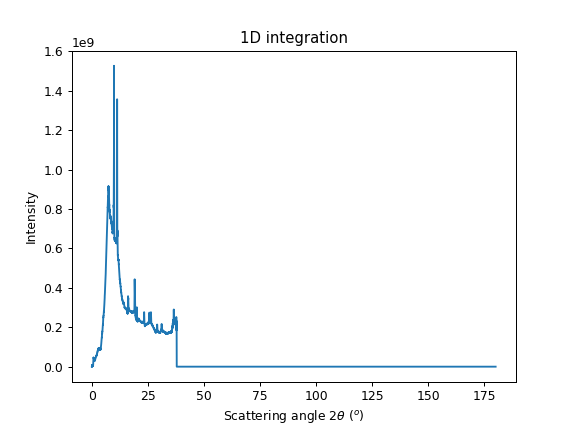

<IPython.core.display.Javascript object>


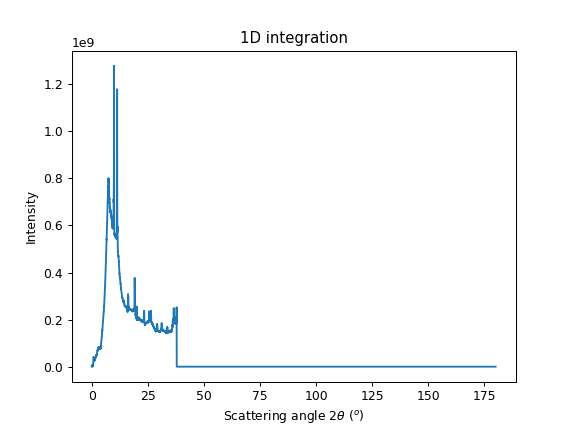

<IPython.core.display.Javascript object>


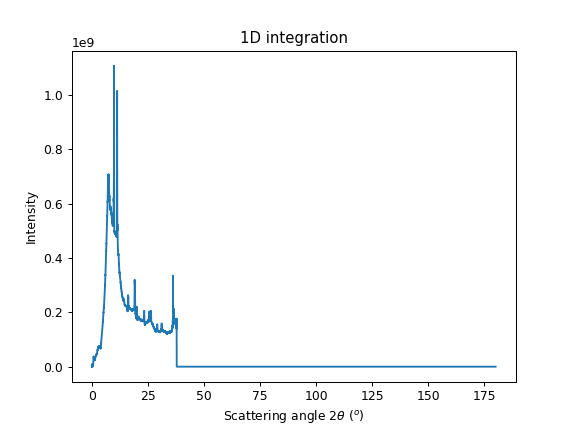

<IPython.core.display.Javascript object>


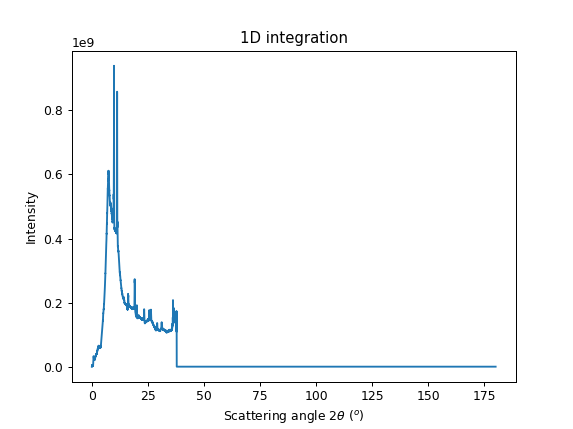

<IPython.core.display.Javascript object>


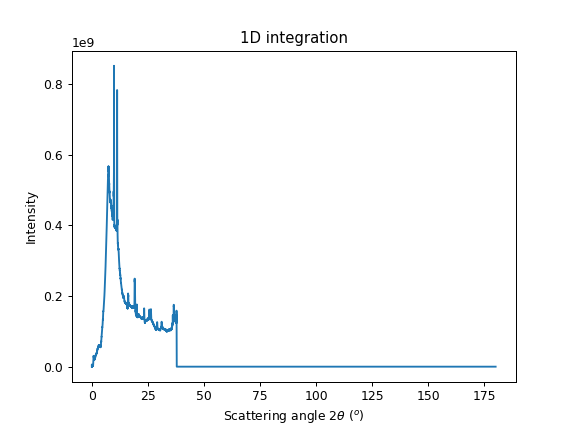

<IPython.core.display.Javascript object>


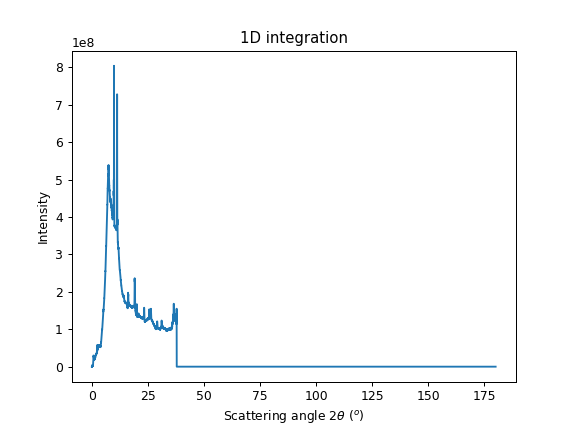

<IPython.core.display.Javascript object>


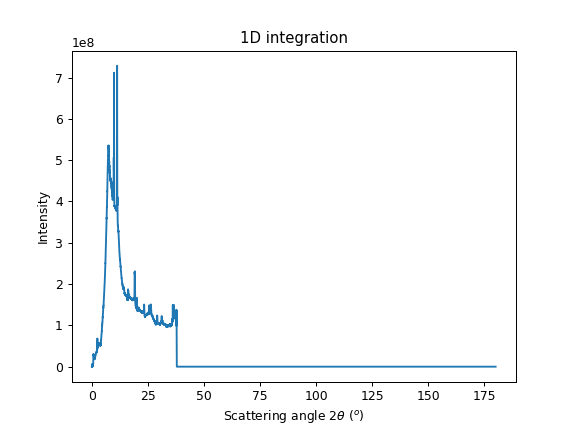

In [29]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               DatasetPathContains("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions,
                               6 # max_rings
                              ) 

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx))),
            mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx+1)))]


samples = [mkSampleMarsTxTzP(idx) for idx in range(77, 92, 2)]

# add button for each file
for sampless in samples:
    for sample in sampless:
        my_cmd_button("silx view --use-opengl-plot " + sample.filename,
                      'Silx View ' + os.path.basename(sample.filename))
        
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 10000, 0, img)
    return img

for sample in samples:
    integrate_mars_tx_tz(json, sample, f, lst_mask=mask, n=50000, save=True)

In [9]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("MARS/D03-1-CX0__EX__SPARE1-MT__#1/raw_value"),  # tx                               
                               DatasetPathContains("scan_data/actuator_1_1"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions,
                               6 # max_rings
                              )

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx)))]


samples = [mkSampleMarsTxTzP(idx) for idx in chain(range(194, 206), 
                                                   range(211, 237),
                                                   range(238, 255),
                                                   range(399, 520),
                                                   range(522, 524),
                                                   range(528, 529),
                                                   range(530, 582))]
                             
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

for sample in samples:
    #print(sample)
    integrate_mars_tx_tz(json, sample, f, n=50000, save=True, no_plot=True)

area_pixel=2.349807733349531 area_sum=2.3889887146976205, Error= -0.016674122223710175
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.38